In [12]:
import pandas as pd
import prophet
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# import logging
# logging.getLogger('prophet').setLevel(logging.WARNING)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [13]:
df = pd.read_csv("Data/Edu_TS_all.csv", sep=";", index_col=0,
                   parse_dates=True)

po = pd.DataFrame(df['Unique Visitors'])

In [14]:
po = po.reset_index()
po.rename(columns={'Date':'ds', 'Unique Visitors':'y'}, inplace=True)
po['ds'] = pd.to_datetime(po['ds'], dayfirst=True, utc=True)
po['ds'] = po['ds'].dt.strftime("%m.%d.%Y")

12:20:44 - cmdstanpy - INFO - Chain [1] start processing
12:20:44 - cmdstanpy - INFO - Chain [1] done processing


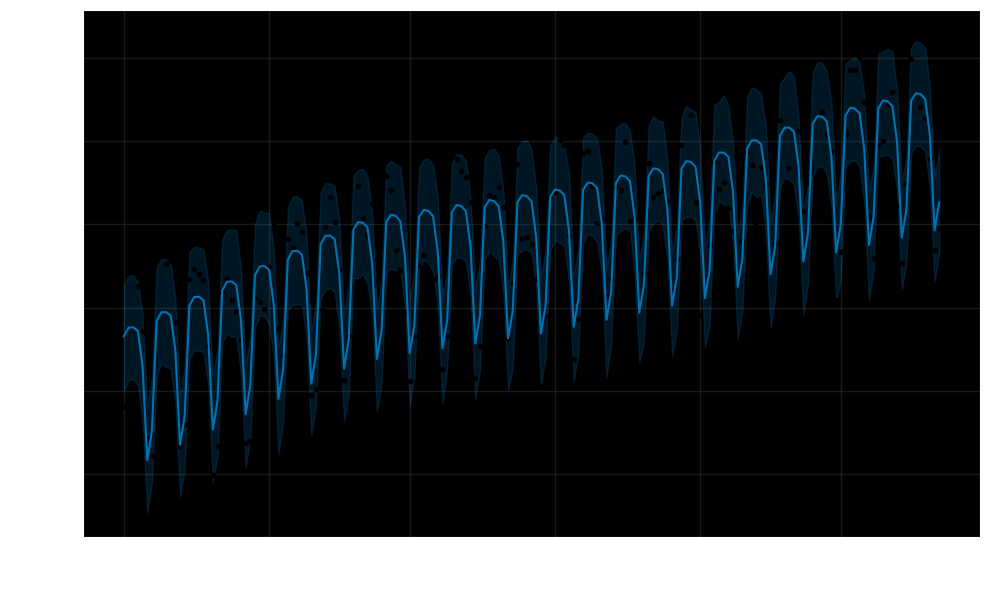

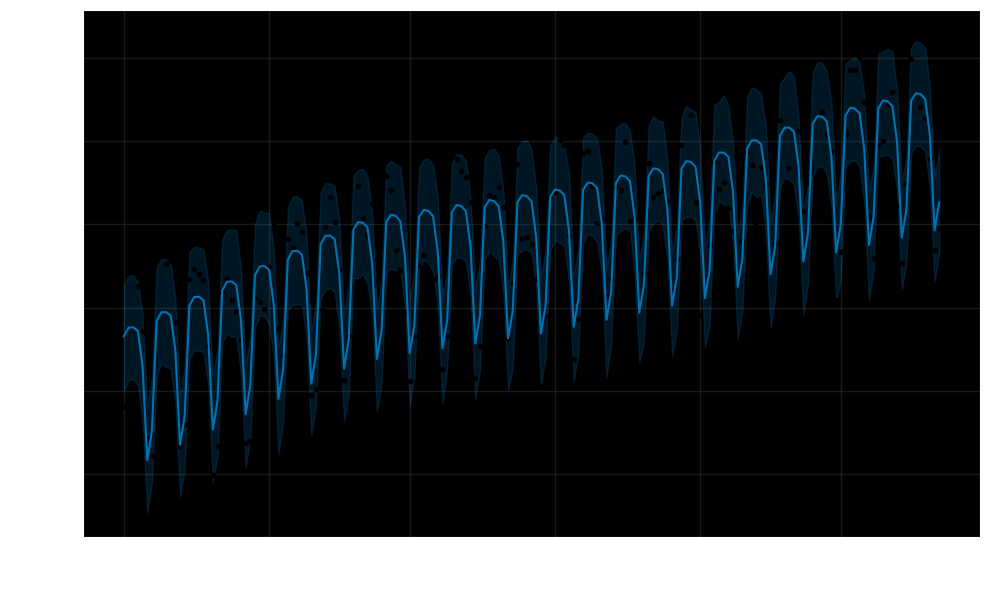

In [15]:
model = prophet.Prophet(changepoint_range=1, changepoint_prior_scale=0.25)
model.fit(po)
forecast = model.predict(po)
model.plot(forecast, uncertainty=True)

In [16]:
forecast_trace = go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast')

# Create layout
layout = go.Layout(title='Outlier Detection with Prophet Forecast', xaxis=dict(title='Date'), yaxis=dict(title='Value'))

# Plot
fig = go.Figure(data=[forecast_trace], layout=layout)
fig.show()

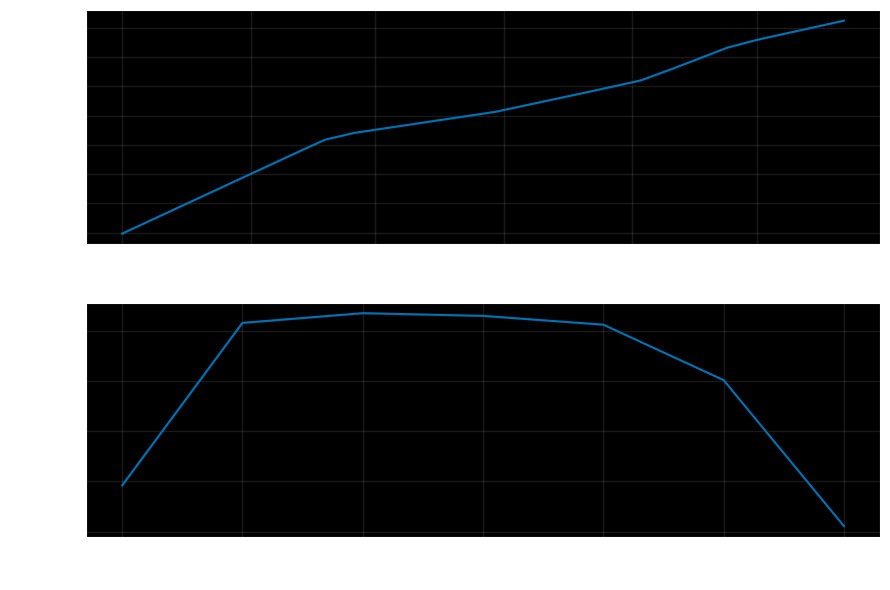

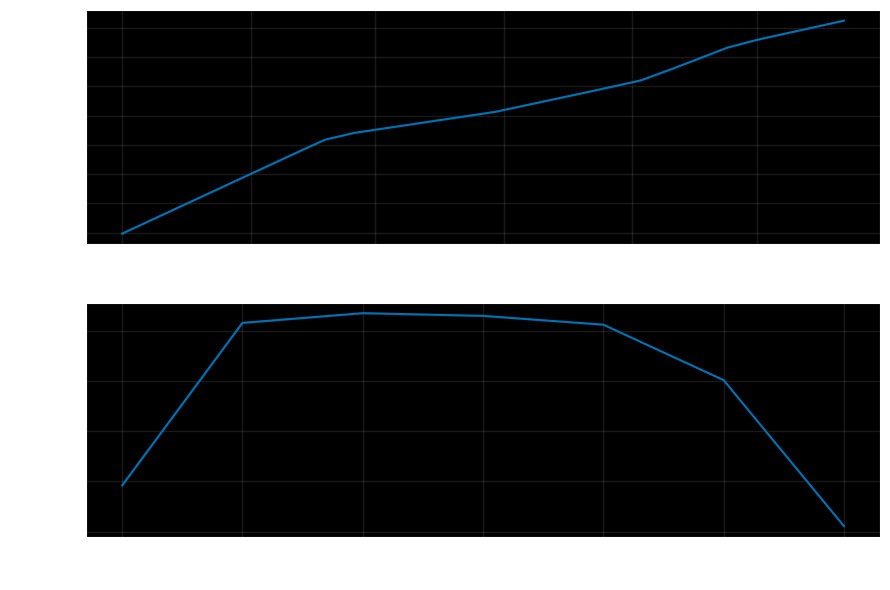

In [17]:
model.plot_components(forecast)

In [18]:
forecast_df = forecast[['ds','yhat','yhat_upper','yhat_lower']]
forecast_df['ds'] = forecast_df['ds'].dt.strftime("%m.%d.%Y")
forecast_df

/var/folders/qf/wr_f6ft15x93_rzk866s88340000gn/T/ipykernel_7961/1715788404.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,yhat,yhat_upper,yhat_lower
0,05.01.2023,38267.176151,41334.781504,34962.188931
1,05.02.2023,38786.483888,41904.022733,35661.851296
2,05.03.2023,38809.822301,41950.456431,35678.459496
3,05.04.2023,38590.520117,41525.662043,35324.476849
4,05.05.2023,36509.522641,39595.980114,33231.622068
...,...,...,...,...
170,10.18.2023,52840.452466,55918.087369,49706.666603
171,10.19.2023,52552.135562,55643.279552,49401.933441
172,10.20.2023,50402.123366,53190.610696,47131.875267
173,10.21.2023,44640.958128,47842.066003,41528.622939


In [19]:
#Merging two dataset to have the actual and prediction values
forecasting_final = pd.merge(forecast_df, po, how='inner',
                                     left_on = 'ds', right_on = 'ds')
forecasting_final['ds'] = pd.to_datetime(forecasting_final['ds'])

# We calculate the prediction error here and uncertainty 
forecasting_final['error'] = forecasting_final['y'] - forecasting_final['yhat']
forecasting_final['uncertainty'] = forecasting_final['yhat_upper'] - forecasting_final['yhat_lower']

# We this factor we can identify the outlier or anomaly. 
# This factor can be customized based on the data
factor = 1.5
forecasting_final['anomaly'] = forecasting_final.apply(lambda x: 'Yes' 
      if(np.abs(x['error']) >  factor*x['uncertainty']) else 'No', axis = 1)

In [20]:
color_discrete_map = {'Yes': 'rgb(255,12,0)', 'No': 'blue'}
fig = px.scatter(forecasting_final, x='ds', y='y', color='anomaly', title='Anomaly',
                 color_discrete_map=color_discrete_map, trendline="lowess",
                   trendline_options=dict(frac=0.1))
fig.show()

In [21]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(forecasting_final['yhat'],forecasting_final['y'])
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = median_absolute_error(forecasting_final['yhat'],forecasting_final['y'])
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(forecasting_final['yhat'],forecasting_final['y'])
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = sqrt(int(mean_squared_error(forecasting_final['yhat'],forecasting_final['y'])))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(forecasting_final['yhat'],forecasting_final['y'])
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

Mean Absolute Error (MAE): 1949.64
Median Absolute Error (MedAE): 1658.51
Mean Squared Error (MSE): 6102136.29
Root Mean Squared Error (RMSE): 2470.25
Mean Absolute Percentage Error (MAPE): 0.04 %
